Business Planning to manage inventory, predict liquidity needs and maximise profitability with data.

In [3]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats

In [4]:
calendar_data=pd.read_csv('/Users/pratiibhas/Downloads/m5-forecasting-accuracy/calendar.csv')
sales_data =pd.read_csv('/Users/pratiibhas/Downloads/m5-forecasting-accuracy/sales_train_evaluation.csv')
sell_prices= pd.read_csv('/Users/pratiibhas/Downloads/m5-forecasting-accuracy/sell_prices.csv')

In [5]:
sales_data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [6]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
calendar_data.head(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


## EDA : Know your data

In [8]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [9]:
sales_data.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [10]:
if sales_data.duplicated().any():
    print("There are duplicate rows in sell_prices.")
else:
    print("No duplicate rows found.")

No duplicate rows found.


## Problem Statement: How to use business analytics to help a company selling renewable coffee cups?

## 1. Inventory Management Simulation

1. When to reorder?
2. Daily demand trends.
3. Detect overstock scenarios.

In [11]:
sales_data.head()
# the number of units of that item sold on each day, from d_1 to d_1941

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


### **1. Daily Demand sales**

In [12]:
sales_data['item_id'].nunique()
sales_data['store_id'].nunique()

10

In [40]:
day_cols= [col for col in sales_data.columns if col.startswith('d_')] # day coluumns

# sum total sales per day
daily_sales=sales_data[day_cols].sum().reset_index()
daily_sales.columns = ["day", "total_sales"]

# Step 1: Melt the sales data (from wide to long)
sales_melted = sales_data.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='total_sales'
)

#  Merge with calendar to get actual dates (left join)
demand_sales = pd.merge(sales_melted, calendar_data[['date', 'd']], on='d', how='left')

#  convert `date` to datetime format
demand_sales['date'] = pd.to_datetime(demand_sales['date'])

# View the first few rows
demand_sales.head(25)

,id,item_id,dept_id,cat_id,store_id,state_id,d,total_sales,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29


In [14]:
demand_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           object        
 1   item_id      object        
 2   dept_id      object        
 3   cat_id       object        
 4   store_id     object        
 5   state_id     object        
 6   d            object        
 7   total_sales  int64         
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 4.0+ GB


In [15]:
# Adding  year column
demand_sales['year']=demand_sales['date'].dt.year

/Users/pratiibhas/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


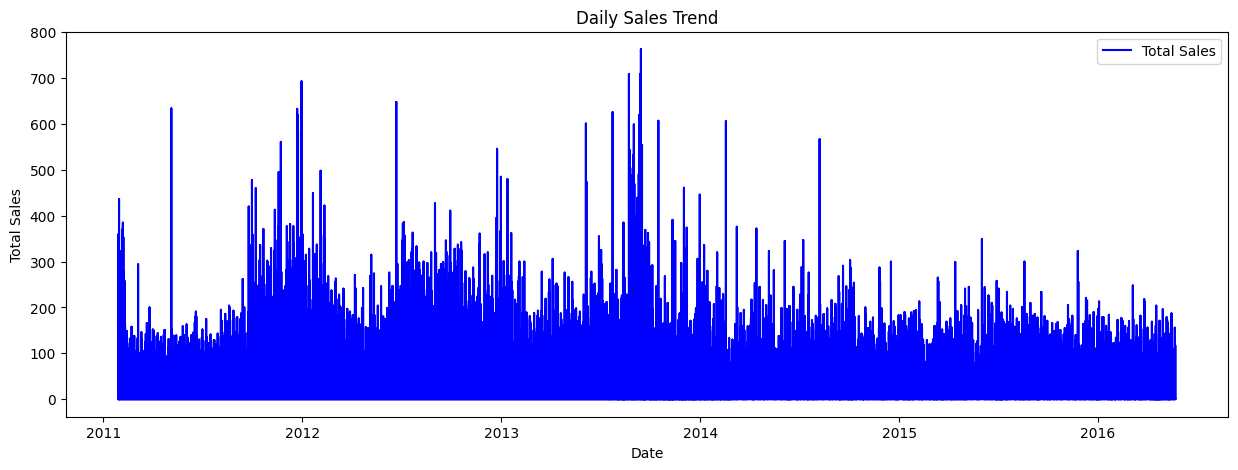

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(demand_sales["date"], demand_sales["total_sales"], label="Total Sales", color="blue")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Daily Sales Trend")
plt.legend()
plt.show()

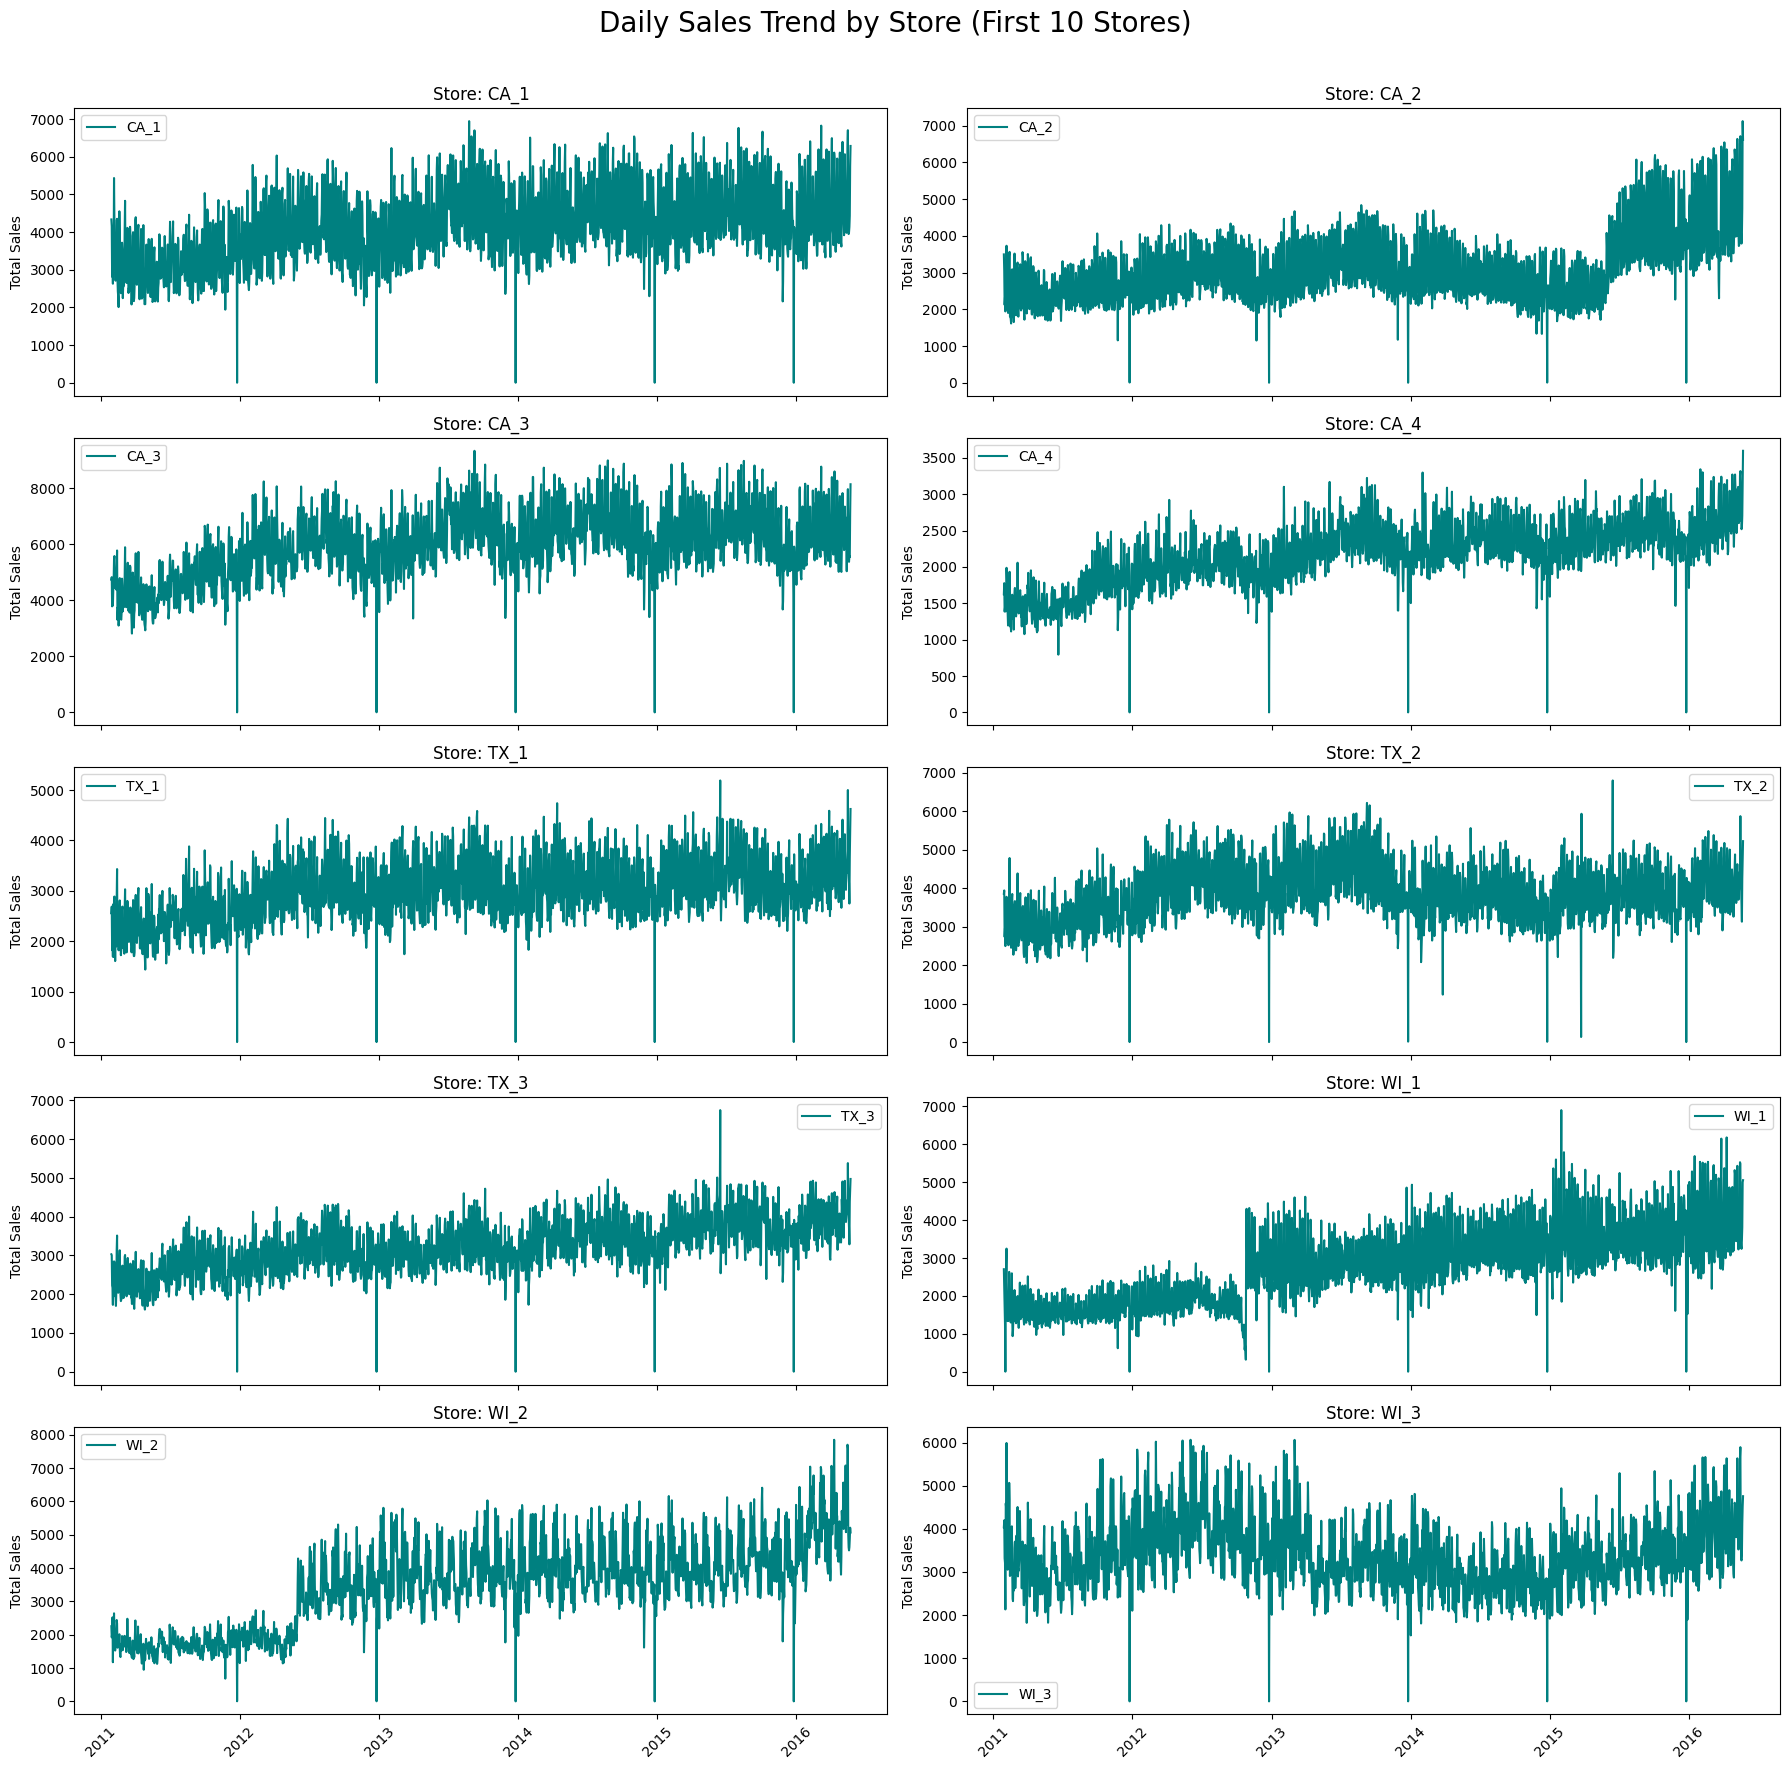

In [17]:
store_sales = demand_sales.groupby(['store_id', 'date'])['total_sales'].sum().reset_index()

# Get unique stores and choose the first 10 for plotting
stores = store_sales['store_id'].unique()[:10]

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(18, 18), sharex=True)
axes = axes.flatten()

# Plot each store's data
for i, store in enumerate(stores):
    data = store_sales[store_sales['store_id'] == store]
    axes[i].plot(data['date'], data['total_sales'], label=store, color='teal')
    axes[i].set_title(f"Store: {store}")
    axes[i].set_ylabel("Total Sales")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

plt.suptitle("Daily Sales Trend by Store (First 10 Stores)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**7-day moving averages to reduce all the noise.**

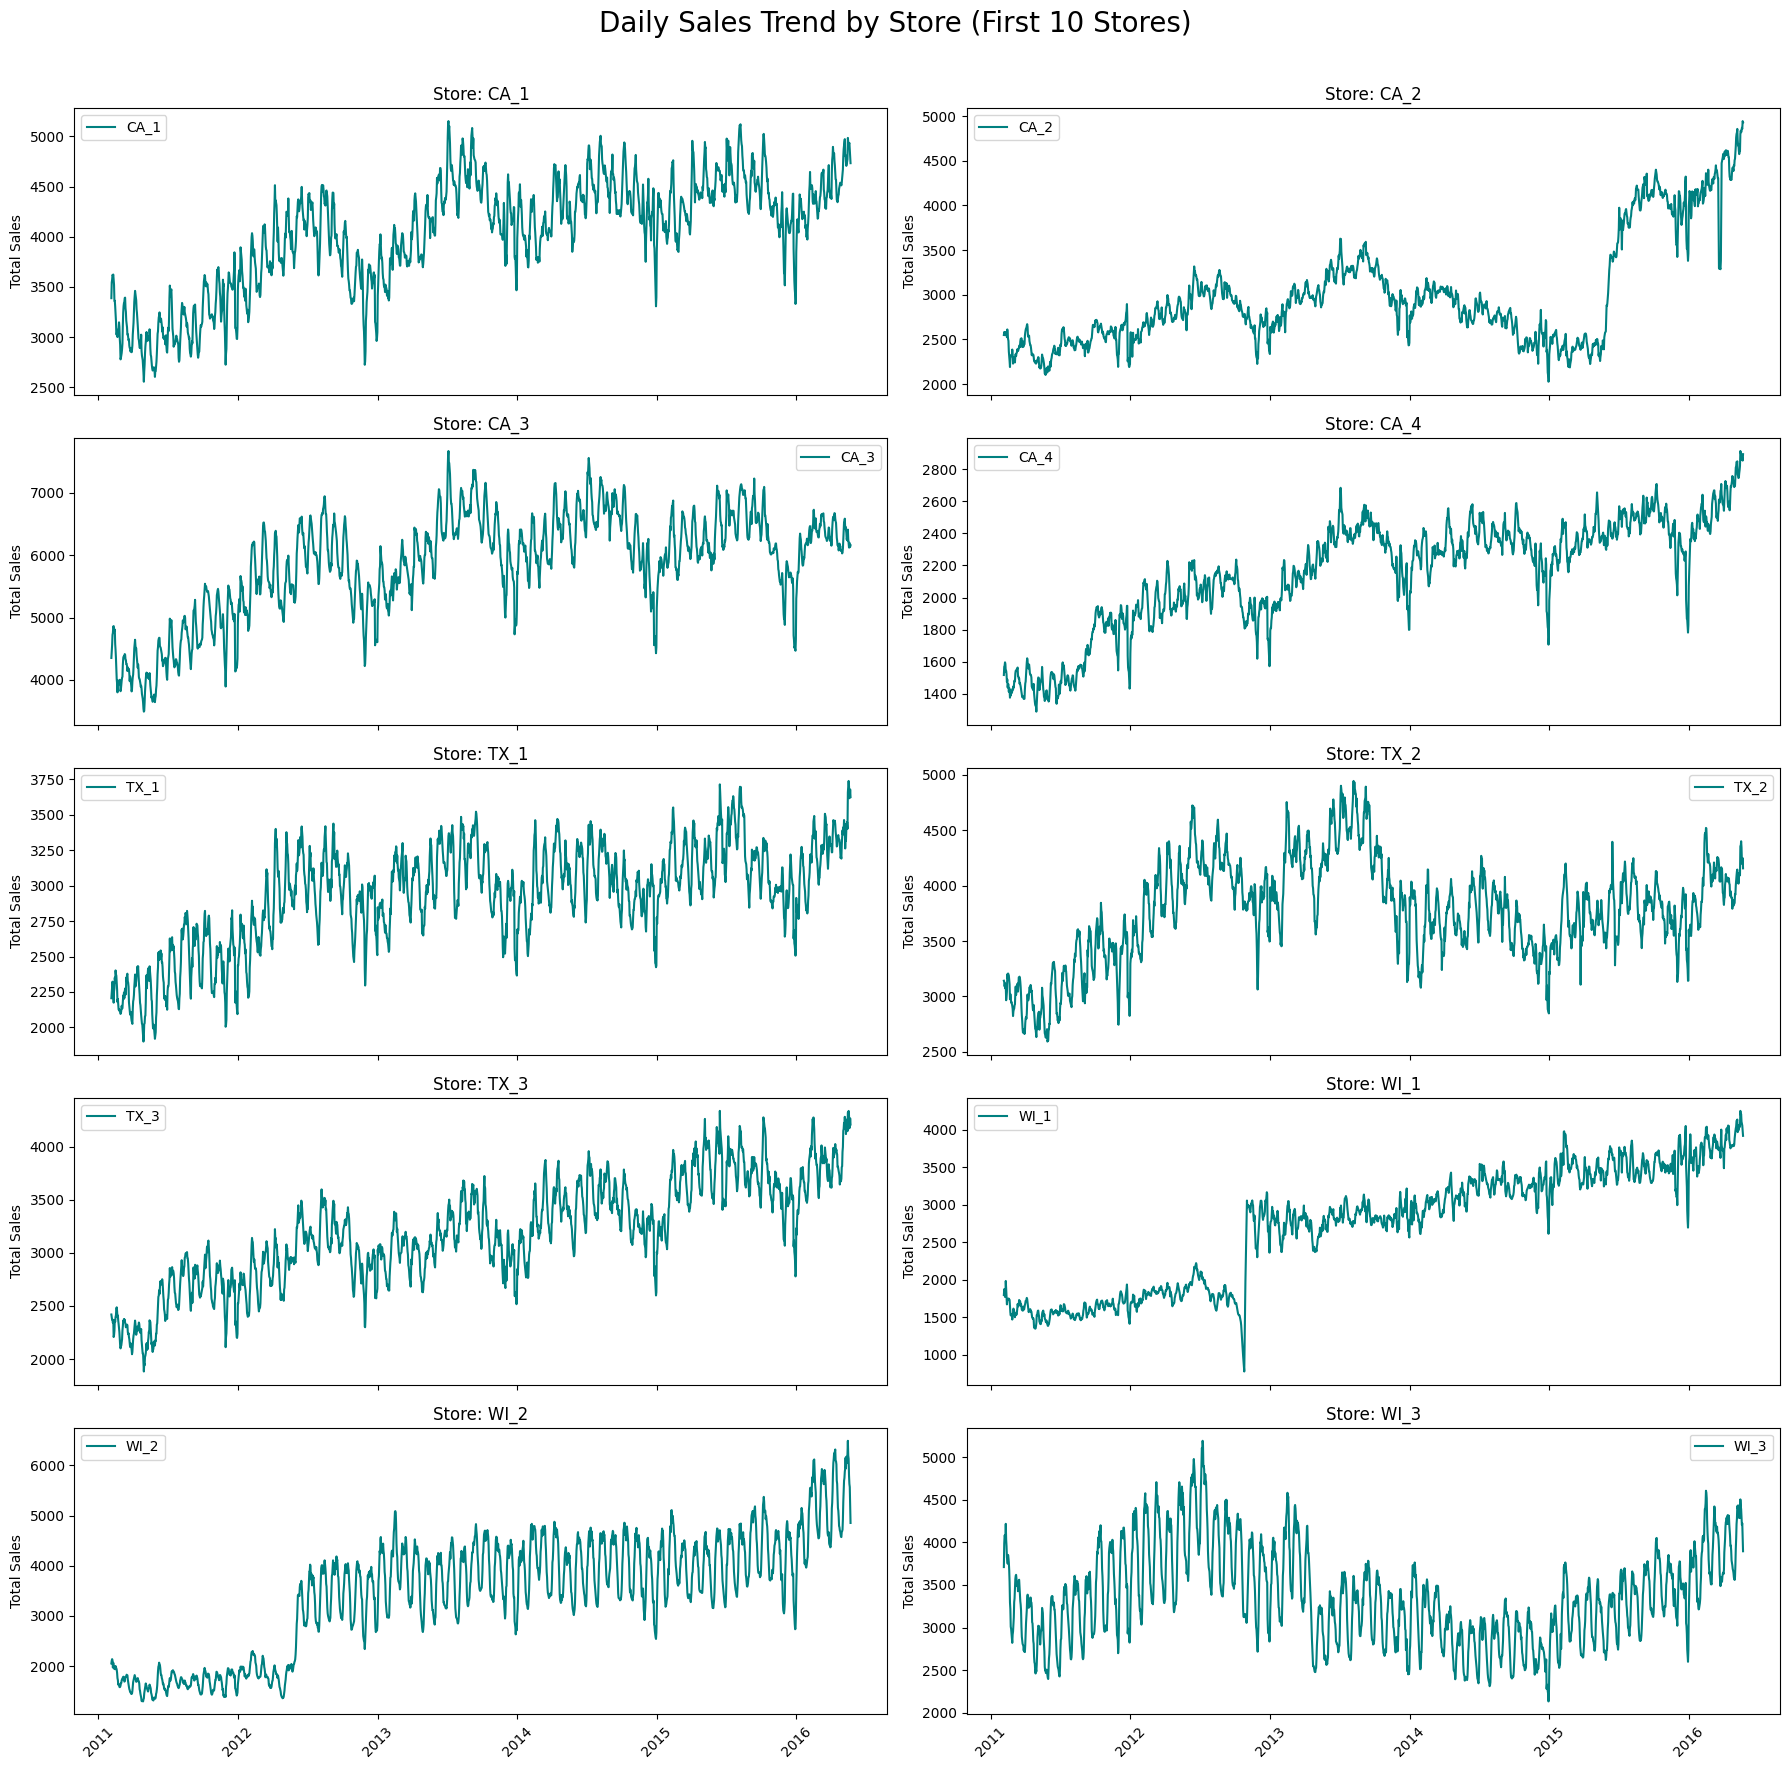

In [18]:
# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(18, 18), sharex=True)
axes = axes.flatten()

# Plot each store's data
for i, store in enumerate(stores):

    data = store_sales[store_sales['store_id'] == store]
    axes[i].plot(data['date'], data['total_sales'].rolling(window=7).mean(), label=store, color='teal')
    axes[i].set_title(f"Store: {store}")
    axes[i].set_ylabel("Total Sales")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

plt.suptitle("Daily Sales Trend by Store (First 10 Stores)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

This graph helps us in understanding:
1. Seasonal demand
2. Growth/ Decline of stores
3. Demand spikes, likely related to holidays.

- Here we have 10 stores demand graphs and as we can see there demand patterns are quite differentiating from each other so, treating them at the same level is not appropriate.
- Also in case of inventory management, lead times can differ for various stores, demand patterns are differing as we can see.
- Cash flow decisions are local. Cash flow tied to inventory needs at each store. Overstock in Store A ≠ understock in Store B.

SOLUTION:
- Writing reproducible code that can be used again and again for store wise analysis.

For each SKU, you would like to build a simple simulation model to test several inventory rules and estimate the impact on:

- Performance Metrics
- Cycle Service Level (CSL): probability to have a stock-out for each cycle (%)
- Item Fill Rate (IFR): percentage of customer demand met without stock-out (%)


### **2. When to reorder? and when is there risk of stockouts.**

### For store CA_1

As we know reorder point = lead time* Average daily demand

## Continuous Review Policy: Order Point, Order Quantity (s, Q)

**To get better outline of our inventory management we will leep track of following metrices:**
1. Replenishment Lead times , LD
2. Customer demand Standard deviation, SIGMA
3. Order Quantity ,Q
4. Cycle Service level, CSL : probability to have a stock-out for each cycle (%)
5. Initial Inventory
6. Inventory fill rate (IFR): percentage of customer demand met without stock-out (%)

In [19]:
demand_sales.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,total_sales,date,year
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011


### Function to calculate store sales per day

In [20]:
def store_sale_sum(store_id, df):
    # Filter for the given store
    store_df = df[df['store_id'] == store_id]
    
    # Group by date and sum the total sales
    return store_df.groupby('date')['total_sales'].sum()

store_sale_sum('CA_1',demand_sales)   

date
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
              ... 
2016-05-18    3995
2016-05-19    4136
2016-05-20    4433
2016-05-21    5764
2016-05-22    6289
Name: total_sales, Length: 1941, dtype: int64

### Calculating average demand of each item

In [21]:
def avg_daily_demand(store_id,df):
    store_df = df[df['store_id'] == store_id]
    product_daily_avg = (
        store_df.groupby('item_id')['total_sales']
        .mean()
        .reset_index(name='avg_daily_demand')
    )
    return product_daily_avg 

# Then merge with your lead time assumptions per product/store
avg_daily_demand('CA_1',demand_sales)


,item_id,avg_daily_demand
0,FOODS_1_001,0.786193
1,FOODS_1_002,0.481195
2,FOODS_1_003,0.830500
3,FOODS_1_004,8.187532
4,FOODS_1_005,1.167439
...,...,...
3044,HOUSEHOLD_2_512,0.684183
3045,HOUSEHOLD_2_513,0.496136
3046,HOUSEHOLD_2_514,0.302937
3047,HOUSEHOLD_2_515,0.061309


### Performing ABC analysis to prioritise products per store

In [35]:
def abc_analysis(store_id, demand_sales,sell_prices):
    # Step 1: Calculate avg_daily_demand per item for the store
    
    df = avg_daily_demand(store_id, demand_sales)

    # Step 2: Calculate average sell price per item for the store
    store_prices = sell_prices[sell_prices['store_id'] == store_id]
    avg_prices = store_prices.groupby('item_id')['sell_price'].mean().reset_index()
    avg_prices.rename(columns={'sell_price': 'avg_sell_price'}, inplace=True)

    # Step 3: Merge demand with price info
    df = df.merge(avg_prices, on='item_id', how='left')

    # Step 4: Calculate value contribution
    df['value'] = df['avg_daily_demand'] * df['avg_sell_price']

    # Step 5: Sort by value
    df_sorted = df.sort_values('value', ascending=False).copy()

    # Step 6: Calculate cumulative % contribution
    total_value = df_sorted['value'].sum()
    df_sorted['cumulative_value'] = df_sorted['value'].cumsum()
    df_sorted['cumulative_percent'] = 100 * df_sorted['cumulative_value'] / total_value

    # Step 7: Classify into ABC
    def classify(percent):
        if percent <= 80:
            return 'A'
        elif percent <= 95:
            return 'B'
        else:
            return 'C'

    df_sorted['ABC_class'] = df_sorted['cumulative_percent'].apply(classify)

    return df_sorted[['item_id','ABC_class']]

In [36]:
abc_analysis('CA_1',demand_sales,sell_prices)  

,item_id,ABC_class
732,FOODS_3_120,A
702,FOODS_3_090,A
1198,FOODS_3_586,A
814,FOODS_3_202,A
1199,FOODS_3_587,A
...,...,...
1875,HOBBIES_2_023,C
1917,HOBBIES_2_065,C
1899,HOBBIES_2_047,C
1862,HOBBIES_2_010,C


### Calculate order quantity

In [24]:
demand_sales['store_id'].unique

<bound method Series.unique of 0           CA_1
1           CA_1
2           CA_1
3           CA_1
4           CA_1
            ... 
59181085    WI_3
59181086    WI_3
59181087    WI_3
59181088    WI_3
59181089    WI_3
Name: store_id, Length: 59181090, dtype: object>

In [25]:
print(demand_sales.index.names)
print(demand_sales.columns)
print('store_id' in demand_sales.columns)

[None]
Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'total_sales', 'date', 'year'],
      dtype='object')
True


In [26]:
print(type(demand_sales))
print(demand_sales.columns)
print(demand_sales.head())

<class 'pandas.core.frame.DataFrame'>
Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'total_sales', 'date', 'year'],
      dtype='object')
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  total_sales       date  year  
0       CA  d_1            0 2011-01-29  2011  
1       CA  d_1            0 2011-01-29  2011  
2       CA  d_1            0 2011-01-29  2011  
3       CA  d_1            0 2011-01-29  2011  
4       CA  d_1            0 2011-01-29  2011  


In [27]:
demand_sales= demand_sales.reset_index()
demand_sales.columns

Index(['index', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'd', 'total_sales', 'date', 'year'],
      dtype='object')

In [29]:
def order_qty(df, sell_prices, store, review_period_days=7):
    store_df = df[df['store_id'] == store].copy()

    # Avg daily demand per item
    avg_demand = avg_daily_demand(store, store_df)
    demand_map = avg_demand.set_index('item_id')['avg_daily_demand']
    store_df['avg_daily_demand'] = store_df['item_id'].map(demand_map)

    # ABC classification per item
    df_classified = abc_analysis(store, store_df, sell_prices)
    abc_map = df_classified.set_index('item_id')['ABC_class']
    store_df['ABC_class'] = store_df['item_id'].map(abc_map)

    # Calculate and adjust order quantity
    store_df['order_quantity'] = store_df['avg_daily_demand'] * review_period_days
    store_df.loc[store_df['ABC_class'] == 'A', 'order_quantity'] *= 1.2

    return store_df[['item_id', 'order_quantity', 'ABC_class']]


In [30]:
# Get the full DataFrame from abc_analysis
classified_df = abc_analysis('CA_1', demand_sales,sell_prices)
# Filter the DataFrame to show only Class A
class_a_df = classified_df[classified_df['ABC_class'] == 'A']
class_a_df

,item_id,avg_daily_demand,avg_sell_price,value,cumulative_value,cumulative_percent,ABC_class
732,FOODS_3_120,32.512622,4.980000,161.912859,161.912859,1.362853,A
702,FOODS_3_090,66.385884,1.388546,92.179860,254.092719,2.138750,A
1198,FOODS_3_586,45.773313,1.595957,73.052259,327.144978,2.753645,A
814,FOODS_3_202,16.396188,4.326454,70.937350,398.082328,3.350739,A
1199,FOODS_3_587,26.973725,2.557305,68.980041,467.062368,3.931358,A
...,...,...,...,...,...,...,...
3000,HOUSEHOLD_2_468,0.301906,9.202695,2.778351,9492.206734,79.897819,A
295,FOODS_2_080,1.275631,2.176667,2.776624,9494.983358,79.921190,A
1695,HOBBIES_1_266,0.592993,4.681352,2.776011,9497.759368,79.944557,A
439,FOODS_2_225,1.105100,2.507660,2.771216,9500.530584,79.967882,A


### Calculate safety cost

First and foremost to calculate safety stock we need to define,k  the highest k is the best your performance will be:

- fix your target for any of the two metrics (e.g, I want my CSL to be 95%)
- calculate k to reach this target
- fix your reorder point

From the two metrices Cycle service level and inventory fill rate, here we will use Cycle service level and let's assume it is 95% making our k=1.64

**We Assumed lead time is same for all products**

In [31]:
import math

def calculate_safety_stock(df, store, Z=1.64, lead_time=3):  # Default Z-score for 95% service level
    # Filter the dataframe for the specific store
    df_store = df[df['store_id'] == store]
    
    # Group by item and calculate the standard deviation of sales for each item
    df_store['safety_stock'] = df_store.groupby('item_id')['total_sales'].transform(lambda x: Z * x.std() * math.sqrt(lead_time))
    
    return df_store


In [32]:
calculate_safety_stock(demand_sales,'CA_1')

/var/folders/1q/dnpwvw112w7bxtjst50whx0r0000gn/T/ipykernel_18346/3276410495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['safety_stock'] = df_store.groupby('item_id')['total_sales'].transform(lambda x: Z * x.std() * math.sqrt(lead_time))


,index,id,item_id,dept_id,cat_id,store_id,state_id,d,total_sales,date,year,safety_stock
0,0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,2.011236
1,1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1.615127
2,2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1.424388
3,3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,5.643656
4,4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,3.671810
...,...,...,...,...,...,...,...,...,...,...,...,...
59153644,59153644,FOODS_3_823_CA_1_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,d_1941,2,2016-05-22,2016,3.483907
59153645,59153645,FOODS_3_824_CA_1_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,d_1941,0,2016-05-22,2016,3.423095
59153646,59153646,FOODS_3_825_CA_1_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,d_1941,1,2016-05-22,2016,3.843672
59153647,59153647,FOODS_3_826_CA_1_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,d_1941,1,2016-05-22,2016,4.573570


In [33]:
demand_sales['reorder point']= avg_daily_demand('CA_1',demand_sales)['avg_daily_demand']*3
demand_sales = calculate_safety_stock(demand_sales,'CA_1')
demand_sales


/var/folders/1q/dnpwvw112w7bxtjst50whx0r0000gn/T/ipykernel_18346/3276410495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['safety_stock'] = df_store.groupby('item_id')['total_sales'].transform(lambda x: Z * x.std() * math.sqrt(lead_time))


,index,id,item_id,dept_id,cat_id,store_id,state_id,d,total_sales,date,year,reorder point,safety_stock
0,0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,2.358578,2.011236
1,1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1.443586,1.615127
2,2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,2.491499,1.424388
3,3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,24.562597,5.643656
4,4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,3.502318,3.671810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59153644,59153644,FOODS_3_823_CA_1_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,d_1941,2,2016-05-22,2016,NaN,3.483907
59153645,59153645,FOODS_3_824_CA_1_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,d_1941,0,2016-05-22,2016,NaN,3.423095
59153646,59153646,FOODS_3_825_CA_1_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,d_1941,1,2016-05-22,2016,NaN,3.843672
59153647,59153647,FOODS_3_826_CA_1_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,d_1941,1,2016-05-22,2016,NaN,4.573570


In [ ]:
demand_sales['difference'] = demand_sales['safety_stock'] - demand_sales['reorder point']
demand_sales['ABC_Class']= demand_sales

# Sort by largest difference
top_risk_items = demand_sales[['item_id', 'safety_stock', 'reorder point', 'difference']].drop_duplicates()
top_risk_items = top_risk_items.sort_values(by='difference', ascending=False).head(10)

print(top_risk_items)


          item_id  safety_stock  reorder point  difference
2314  FOODS_3_090    163.332836       5.299845  158.032991
2344  FOODS_3_120     94.928689       2.803709   92.124980
3029  FOODS_3_808     69.324563       0.542504   68.782059
3006  FOODS_3_785     67.512989       0.496136   67.016853
2542  FOODS_3_318     62.403469       0.986090   61.417380
2811  FOODS_3_587     60.593677       1.010819   59.582858
2859  FOODS_3_635     54.411287       0.601236   53.810051
2765  FOODS_3_541     54.453828       0.659969   53.793859
2476  FOODS_3_252     53.055940       0.544049   52.511890
2810  FOODS_3_586     46.415647       0.162287   46.253359


In [ ]:
def apply_abc_analysis(demand_sales, sell_prices):
    abc_results = []
    
    
    for store in demand_sales['store_id'].unique():
        abc_classified = abc_analysis(store, demand_sales, sell_prices)
        abc_classified['store_id'] = store
        abc_results.append(abc_classified)
    
    # Concatenate all store-wise ABC results
    abc_classified_all = pd.concat(abc_results, axis=0)
    
    # Now merge this back with the original demand_sales
    demand_sales = demand_sales.merge(abc_classified_all[['item_id', 'ABC_class']], on='item_id', how='left')
    
    return demand_sales

# Apply ABC classification and add it to demand_sales
demand_sales = apply_abc_analysis(demand_sales, sell_prices)


In [39]:
demand_sales['difference'] = demand_sales['safety_stock'] - demand_sales['reorder point']

# Sort and view top risky items
top_risk_items = demand_sales[['item_id', 'safety_stock', 'reorder point', 'difference', 'ABC_class']].drop_duplicates()
top_risk_items = top_risk_items.sort_values(by='difference', ascending=False).head(10)

print(top_risk_items)


          item_id  safety_stock  reorder point  difference ABC_class
2314  FOODS_3_090    163.332836       5.299845  158.032991         A
2344  FOODS_3_120     94.928689       2.803709   92.124980         A
3029  FOODS_3_808     69.324563       0.542504   68.782059         A
3006  FOODS_3_785     67.512989       0.496136   67.016853         A
2542  FOODS_3_318     62.403469       0.986090   61.417380         A
2811  FOODS_3_587     60.593677       1.010819   59.582858         A
2859  FOODS_3_635     54.411287       0.601236   53.810051         A
2765  FOODS_3_541     54.453828       0.659969   53.793859         A
2476  FOODS_3_252     53.055940       0.544049   52.511890         A
2810  FOODS_3_586     46.415647       0.162287   46.253359         A


If 'A' class items are flagged in risk items, quick action should be taken, to avoid any future losses.

### Future analysis recommendation

This item-level approach provides precision in calculating demand and reorder points. For strategic insights, the analysis can be rolled up to higher levels — such as store, category, or region — to answer key business questions like:

1. Which stores are consistently overstocked or understocked?

2. Which product categories are most sensitive to lead times?

3. Are there regional differences in replenishment patterns?